In [29]:
# fit_many_transects - Loop through transects and collect fits

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor
from scipy import stats
import statsmodels.api as sm
import pymc as pm

In [3]:
data_dir = 'C:/crs/proj/2025_shoreline_fits/'
#fn = 'Northshore_LT_intersects.csv'
# fn = 'OuterCapeE_intersects_LT.csv'
fn = 'NPS_Shoreline_Intersects_CACO.csv'
df = pd.read_csv(data_dir+fn)

# Convert to datetime format
df["date"] = pd.to_datetime(df["ShorelineI"], format="%m/%d/%Y")

# Function to convert datetime to decimal year
def datetime_to_decimal_year(dt):
    year = dt.year
    start_of_year = pd.Timestamp(f"{year}-01-01")
    end_of_year = pd.Timestamp(f"{year+1}-01-01")
    decimal_year = year + (dt - start_of_year).total_seconds() / (end_of_year - start_of_year).total_seconds()
    return decimal_year

# Apply function to convert each date
df["decimal_year"] = df["date"].apply(datetime_to_decimal_year)
df

,FID,Shape *,TransectID,TransOrder,ShorelineI,BaselineID,Distance,IntersectX,IntersectY,Uncertaint,date,decimal_year
0,0,Point ZM,1,1,5/26/2010,2,17.12,396937.9389,4657522.660,1,2010-05-26,2010.397260
1,1,Point ZM,1,1,9/18/1996,2,68.24,396887.1015,4657528.014,1,1996-09-18,1996.713115
2,2,Point ZM,1,1,4/16/2008,2,20.74,396934.3386,4657523.039,1,2008-04-16,2008.289617
3,3,Point ZM,1,1,8/26/1994,2,64.19,396891.1334,4657527.589,1,1994-08-26,1994.649315
4,4,Point ZM,1,1,9/13/2007,2,23.73,396931.3642,4657523.353,1,2007-09-13,2007.698630
...,...,...,...,...,...,...,...,...,...,...,...,...
31741,31741,Point ZM,828,828,5/8/2014,2,21.30,421405.1118,4632939.255,1,2014-05-08,2014.347945
31742,31742,Point ZM,828,828,10/23/2015,2,45.56,421428.8664,4632944.137,1,2015-10-23,2015.808219
31743,31743,Point ZM,828,828,9/25/2013,2,37.59,421421.0659,4632942.534,1,2013-09-25,2013.731507
31744,31744,Point ZM,828,828,3/28/2019,2,22.16,421405.9455,4632939.427,1,2019-03-28,2019.235616


In [4]:
def r2_from_predictions( x, y, slope, intercept ):
    # For fits that don't return r2, calculate from the data and the fit
    # Compute predicted values
    y_pred = slope * x + intercept
    
    # Compute r2
    SS_total = np.sum((y - np.mean(y)) ** 2)  # Total Sum of Squares
    SS_residual = np.sum((y - y_pred) ** 2)   # Residual Sum of Squares
    r_squared = 1 - (SS_residual / SS_total)
    return r_squared

In [11]:
transects = np.unique(df['TransectID'])
n_list=[]
t_list=[]
yr_start_list=[]
yr_end_list=[]
lat_list=[]
lon_list=[]
OLS_slope_list=[]
OLS_intercept_list=[]
# ...as in a+bx+cx^2
quad_a_list=[]
quad_b_list=[]
quad_c_list=[]
RSS_linear_list=[]
RSS_quad_list=[]
AIC_linear_list=[]
AIC_quad_list=[]
r2adj_linear_list=[]
r2adj_quad_list=[]
p_value_list=[]

# Pre-filter the dataframe to keep only rows where decimal_year >= 1970
dff = df[df["decimal_year"] >= 1970]

tid_list = [500, 501, 502]

for tid in dff["TransectID"].unique():  # Iterate only over existing TransectIDs
#for tid in tid_list:  # Iterate only over existing TransectIDs
    tdf = dff[dff["TransectID"] == tid].sort_values(by="decimal_year")

    if len(tdf) >= 4:  # Ensure at least 3 valid rows
        x = tdf['decimal_year'].values - 1970
        y = tdf['Distance'].values
        #yu = tdf['Bias_Uncer'].values
        
        t_list.append(tid)
        n_list.append(len(x))
        yr_start_list.append(tdf['decimal_year'].values[0])  # First valid year
        yr_end_list.append(tdf['decimal_year'].values[-1])  # Last year
        lon_list.append(tdf['IntersectX'].values[-1])  # Last latitude
        lat_list.append(tdf['IntersectY'].values[-1])  # Last longitude

        # Linear Fit
        X_linear = sm.add_constant(x)
        OLSfit = sm.OLS(y, X_linear).fit()
        OLS_intercept, OLS_slope = OLSfit.params
        OLS_slope_list.append( OLS_slope )
        OLS_intercept_list.append( OLS_intercept )
        RSS_linear = np.sum(OLSfit.resid ** 2)
        RSS_linear_list.append( RSS_linear )
        
        # Quadratic Fit
        X_quadratic = np.column_stack((x, x**2))
        X_quadratic = sm.add_constant(X_quadratic)
        quad_model = sm.OLS(y, X_quadratic).fit()
        quad_params = quad_model.params
        quad_a_list.append( quad_params[0] )
        quad_b_list.append( quad_params[1] )
        quad_c_list.append( quad_params[2] )
        #print(quad_model.params)
        RSS_quad = np.sum(quad_model.resid ** 2)
        RSS_quad_list.append( RSS_quad )
        
        # AIC & Adjusted R^2
        n = len(x)
        AIC_linear = n * np.log(RSS_linear / n) + 2 * 2
        AIC_quad = n * np.log(RSS_quad / n) + 2 * 3
        AIC_linear_list.append( AIC_linear )
        AIC_quad_list.append( AIC_quad )
        
        r2adj_linear_list.append( OLSfit.rsquared_adj )
        r2adj_quad_list.append( quad_model.rsquared_adj )

        # print("Linear Adjusted R^2:", lin_model.rsquared_adj)
        # print("Quadratic Adjusted R^2:", quad_model.rsquared_adj)
        # print("Linear AIC:", AIC_linear)
        # print("Quadratic AIC:", AIC_quad)

        # F-test
        df1, df2 = 2, 3  # Model parameters (p1, p2)
        F = ((RSS_linear - RSS_quad) / (df2 - df1)) / (RSS_quad / (n - df2))
        p_value = 1 - stats.f.cdf(F, df2 - df1, n - df2)
        p_value_list.append( p_value )
        # print("F-test p-value:", p_value)
        
dft = pd.DataFrame({
    "transect": t_list,
    "N": n_list,
    "Year Start": yr_start_list,
    "Year End": yr_end_list,
    "Latitude": lat_list,
    "Longitude": lon_list,
    "OLS intercept": OLS_intercept_list,
    "OLS slope": OLS_slope_list,
    "Quad a": quad_a_list,
    "Quad b": quad_b_list,
    "Quad c": quad_c_list,
    "RSS linear": RSS_linear_list,
    "RSS quad": RSS_quad_list,
    "AIC linear": AIC_linear_list,
    "AIC quad": AIC_quad_list,
    "r2adj linear": r2adj_linear_list,
    "r2adj quad": r2adj_quad_list,
    "p value": p_value_list
})
dft

,transect,N,Year Start,Year End,Latitude,Longitude,OLS intercept,OLS slope,Quad a,Quad b,Quad c,RSS linear,RSS quad,AIC linear,AIC quad,r2adj linear,r2adj quad,p value
0,1,37,1994.649315,2021.260274,4657525.956,396906.6389,108.182399,-1.806157,409.440114,-18.293642,0.215636,12422.910131,6904.165853,219.206050,199.471607,0.339011,0.621844,0.000009
1,2,37,1994.649315,2021.260274,4657575.852,396910.2552,96.611580,-1.403562,366.759621,-16.188450,0.193368,9951.945358,5514.147091,211.000400,191.153711,0.275249,0.586621,0.000009
2,3,36,1994.649315,2021.260274,4657625.301,396918.1160,87.376369,-1.152838,343.970275,-15.182641,0.183378,9668.441935,5679.831374,205.351726,188.201684,0.191567,0.510686,0.000032
3,4,36,1994.649315,2021.260274,4657677.069,396929.3609,79.696324,-1.046049,326.589836,-14.545463,0.176446,9114.691126,5421.954669,203.228459,186.528938,0.168971,0.490675,0.000040
4,5,36,1994.649315,2021.260274,4657727.803,396942.9470,69.827005,-0.962070,320.995331,-14.695218,0.179501,9766.824875,5945.106320,205.716200,189.844971,0.133817,0.456774,0.000059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,844,34,1994.649315,2021.260274,4632152.268,421562.1740,133.285366,-2.155748,66.493132,1.514214,-0.048060,5335.068236,5075.054146,175.893679,176.194886,0.623703,0.630496,0.216981
840,55,36,1994.649315,2021.260274,4659409.840,398759.3315,-53.073312,3.529812,163.295394,-8.328794,0.155126,8058.309432,5290.577378,198.793845,185.645894,0.759144,0.837077,0.000216
841,56,35,1994.649315,2021.260274,4659419.050,398809.8175,-47.413475,3.353250,176.922963,-8.941325,0.160727,9211.336254,6274.364161,199.049475,187.610778,0.711799,0.797556,0.000504
842,551,35,1994.649315,2021.260274,4646198.456,417494.1469,111.388462,-1.719979,172.599499,-5.083248,0.044037,5530.343777,5315.988606,181.193002,181.809418,0.516286,0.520505,0.264424


In [12]:
# Save to CSV
csv_filename = fn.replace(".csv", "NPS_slope_fits.csv")
dft.to_csv(data_dir+csv_filename, index=False)

# Print confirmation
print(f"DataFrame saved to {data_dir+csv_filename}")

DataFrame saved to C:/crs/proj/2025_shoreline_fits/NPS_Shoreline_Intersects_CACONPS_slope_fits.csv


In [13]:
dft = pd.read_csv( data_dir+csv_filename )
dft.describe()

,transect,N,Year Start,Year End,Latitude,Longitude,OLS intercept,OLS slope,Quad a,Quad b,Quad c,RSS linear,RSS quad,AIC linear,AIC quad,r2adj linear,r2adj quad,p value
count,844.000000,844.000000,844.000000,844.000000,8.440000e+02,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000,8.440000e+02
mean,422.500000,37.613744,1994.649315,2021.260274,4.649785e+06,412388.346323,85.440658,-0.999574,197.339228,-7.096577,0.079551,8526.293267,6567.305101,204.425919,197.196138,0.359403,0.478572,1.493927e-01
std,243.786108,1.200079,0.000000,0.000000,8.712731e+03,7503.205361,51.277818,1.422705,132.351908,7.363472,0.098769,4046.895845,2792.785321,17.079304,15.491275,0.224983,0.199594,2.629788e-01
min,1.000000,33.000000,1994.649315,2021.260274,4.632152e+06,396906.638900,-84.708980,-3.224655,-356.200013,-21.960235,-0.338598,2468.212882,2046.322107,149.686230,147.569845,-0.028680,-0.059222,7.245242e-10
25%,211.750000,37.000000,1994.649315,2021.260274,4.642372e+06,406445.369025,66.326643,-1.887268,135.118542,-11.794336,0.026032,5700.032238,4592.127101,192.904796,185.957651,0.153808,0.350781,3.162899e-04
50%,422.500000,38.000000,1994.649315,2021.260274,4.651912e+06,414560.266300,92.655255,-1.231767,211.433365,-8.322368,0.091806,7704.724055,5957.822811,205.001837,197.196648,0.372368,0.487559,1.128025e-02
75%,633.250000,39.000000,1994.649315,2021.260274,4.658055e+06,418996.102475,123.005257,-0.700459,277.974176,-3.298942,0.148485,10020.669010,7791.649299,214.718872,208.215122,0.537826,0.632990,1.514944e-01
max,844.000000,39.000000,1994.649315,2021.260274,4.659579e+06,421562.174000,177.573755,4.311685,509.464688,24.984824,0.320881,26877.156038,21535.551584,252.359971,236.181893,0.853455,0.901516,9.947503e-01


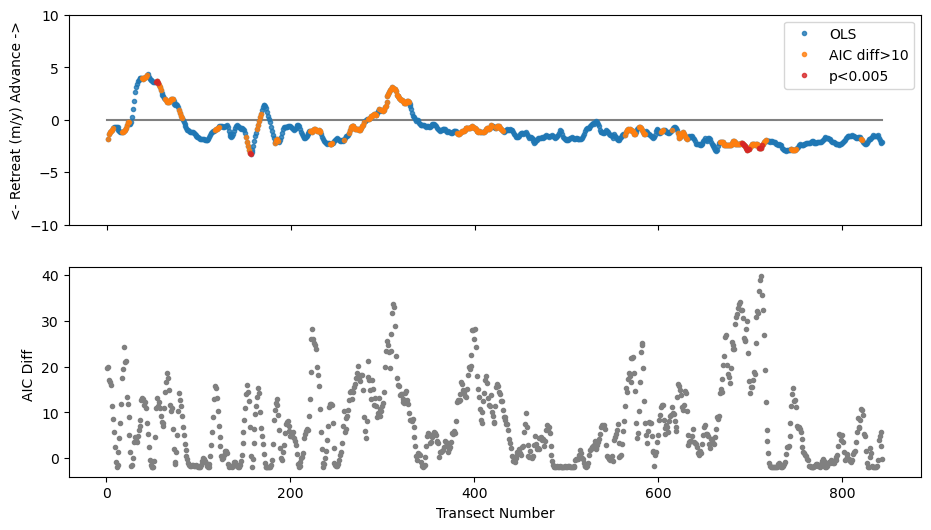

In [25]:
dfp = dft[(dft['p value'] < 0.05) & (dft['r2adj quad'] > 0.8)]
dfq = dft[(dft['AIC linear']-dft['AIC quad'] >10)]

colors =['#66c2a5','#fc8d62','#8da0cb']
fig, (ax0, ax1) = plt.subplots(2, 1, figsize = (11,6) )
ax0.plot([0, len(dft['transect'])],[0,0],'-',c='gray')
ax0.plot(dft['transect'],dft['OLS slope'],'.', c='tab:blue', alpha=.8, label='OLS')
ax0.plot(dfq['transect'],dfq['OLS slope'],'.', c='tab:orange', alpha=.8, label='AIC diff>10')
ax0.plot(dfp['transect'],dfp['OLS slope'],'.', c='tab:red', alpha=.8, label='p<0.005')

#ax0.plot(dft['transect'],dft['WLS slope'],'.', c=colors[1], alpha=.8, label='WLS')
#ax0.plot(dft['transect'],dft['TS slope'],'.', c=colors[2], alpha=.8, label='TS')
ax0.set_ylabel('<- Retreat (m/y) Advance ->')
ax0.set_ylim(-10, 10)
ax0.set_xticklabels([])
ax0.legend()
ax1.plot(dft['transect'],dft['AIC linear']-dft['AIC quad'],'.',c='gray')
ax1.set_xlabel('Transect Number')
ax1.set_ylabel('AIC Diff ')
fig_name = fn.replace(".csv", "NPS_slopes_std.png")
plt.savefig(data_dir+fig_name, dpi=200, bbox_inches='tight')

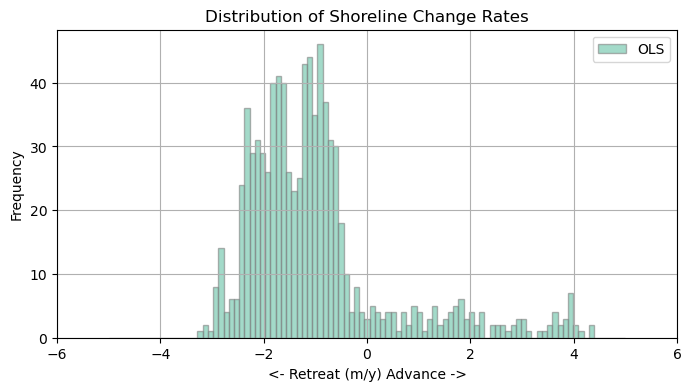

In [24]:
colors =['#66c2a5','#fc8d62','#8da0cb']
bins = np.linspace( -5, 5, 100 )

ax = dft['OLS slope'].hist(figsize=(8, 4), edgecolor='gray', bins=bins, color=colors[0], alpha = .6, label = 'OLS' )
plt.xlim(-6, 6)
plt.legend()

# Add a legend
#ax.legend(group_name)

# Add a title and axis label
ax.set_title('Distribution of Shoreline Change Rates')
ax.set_xlabel('<- Retreat (m/y) Advance ->')
ax.set_ylabel('Frequency')
fig_name = fn.replace(".csv", "slopes_hist.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')

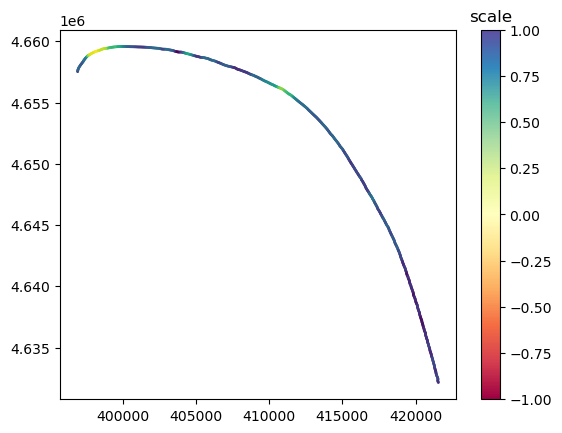

In [28]:
from matplotlib.cm import ScalarMappable
fig, ax = plt.subplots(1, 1)
cmap = plt.get_cmap("Spectral")
slopes = dft['OLS slope']
#norm = plt.Normalize(slopes.min(), slopes.max())
norm = plt.Normalize(-1, 1 )
plt.scatter( dft['Longitude'], dft['Latitude'],s=1, c=dft['OLS slope'] )
smap =  ScalarMappable(norm=norm, cmap=cmap)
smap.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_title("scale")
fig_name = fn.replace(".csv", "slope_map.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')

In [40]:
tid_list = np.linspace( 500, 504, 5).astype(int)
print( tid_list )

[500 501 502 503 504]


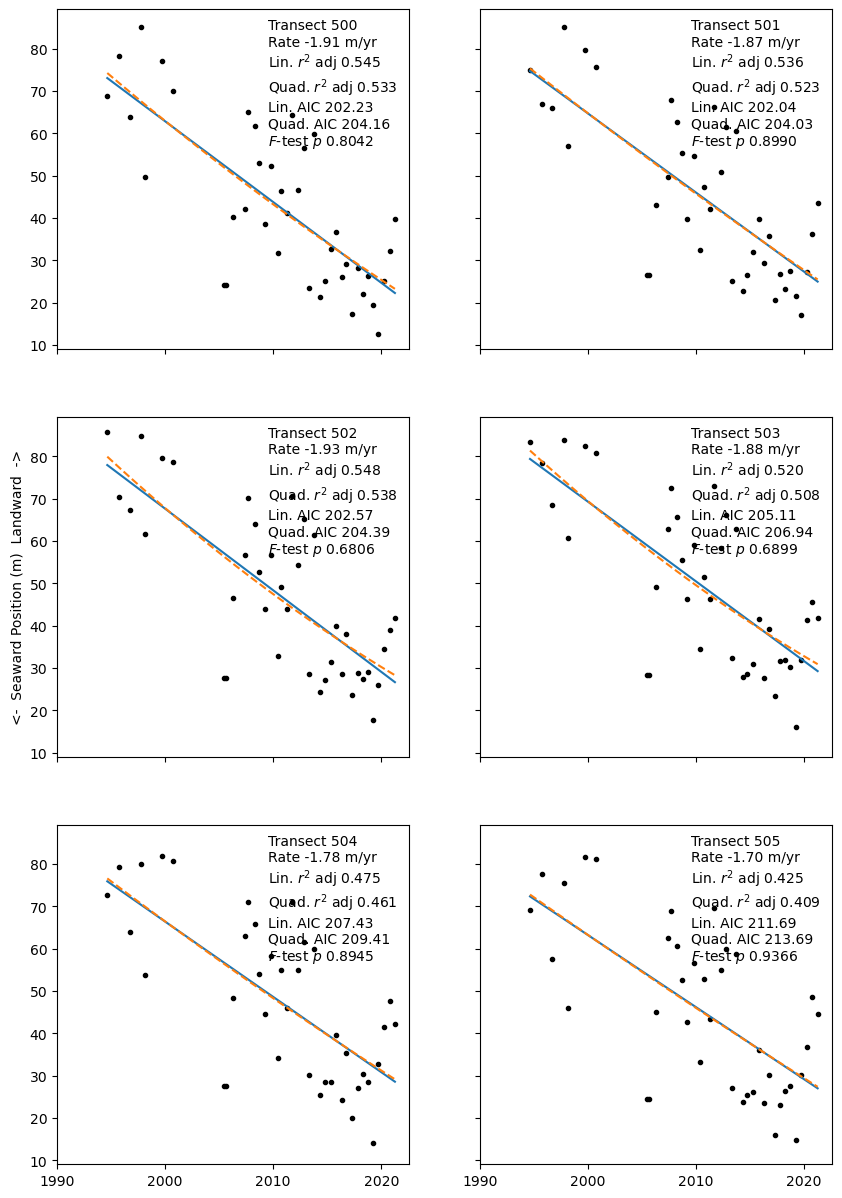

In [42]:
# six-pack plot
#tid_list = [270, 271, 272, 273, 274, 275]
tid_list = np.linspace( 500, 505, 6).astype(int)

# Pre-filter the dataframe to keep only rows where decimal_year >= 1970
dff = df[df["decimal_year"] >= 1970]

fig, axes = plt.subplots(3,2, figsize=(10,15), sharex=True, sharey=True)
for i, tid in enumerate( tid_list ):
    ax = np.ravel(axes)[i]
    tdf = dff[dff["TransectID"] == tid].sort_values(by="decimal_year")
    
    x = tdf['decimal_year'].values - 1970
    y = tdf['Distance'].values
    
    n = len(x)
    yr_start = tdf['decimal_year'].values[0]  # First valid year
    yr_end   = tdf['decimal_year'].values[-1]  # Last year
    lon = tdf['IntersectX'].values[-1]  # Last latitude
    lat = tdf['IntersectY'].values[-1]  # Last longitude
    
    # Linear Fit
    X_linear = sm.add_constant(x)
    OLSfit = sm.OLS(y, X_linear).fit()
    # print('OLS params: ',OLSfit.params)
    OLS_intercept, OLS_slope = OLSfit.params
    RSS_linear = np.sum(OLSfit.resid ** 2)
    
    # Quadratic Fit
    X_quadratic = np.column_stack((x, x**2))
    X_quadratic = sm.add_constant(X_quadratic)
    quad_model = sm.OLS(y, X_quadratic).fit()
    quad_params = quad_model.params
    # print('quad params: ',quad_params)
    
    RSS_quad = np.sum(quad_model.resid ** 2)

    # AIC & Adjusted R^2
    n = len(x)
    AIC_linear = n * np.log(RSS_linear / n) + 2 * 2
    AIC_quad = n * np.log(RSS_quad / n) + 2 * 3
    
    # F-test
    df1, df2 = 2, 3  # Model parameters (p1, p2)
    F = ((RSS_linear - RSS_quad) / (df2 - df1)) / (RSS_quad / (n - df2))
    p_value = 1 - stats.f.cdf(F, df2 - df1, n - df2)

    
    xhat = np.linspace( x[0], x[-1], 21 )
    yhat_lin = xhat*OLS_slope + OLS_intercept
    yhat_quad = quad_params[0] + xhat*quad_params[1] + xhat*xhat*quad_params[2]
    
    #ax.errorbar(x, y, yu, zorder=0)
    ax.plot(x, y, '.k', zorder=1 )
    ax.plot(xhat, yhat_lin,'-')
    ax.plot(xhat, yhat_quad, '--')
    
    xticks = [20, 30, 40, 50]
    xticklabels = ['1990','2000','2010','2020']
    ax.set_xticks( xticks )
    ax.set_xticklabels( xticklabels )
    if(i == 2 ):
        ax.set_ylabel('<-  Seaward Position (m)  Landward  ->')
    ts = 'Transect {0}\nRate {1:.2f} m/yr\nLin. $r^2$ adj {2:.3f}\nQuad. $r^2$ adj {3:.3f}\nLin. AIC {4:.2f}\nQuad. AIC {5:.2f}\n$F$-test $p$ {6:.4f}'.format(tid, OLS_slope, OLSfit.rsquared_adj, quad_model.rsquared_adj, AIC_linear, AIC_quad, p_value)
    plt.text(.6, .6, ts, transform=ax.transAxes)
    figname = 'NPS_nocurve_plots'
    plt.savefig( data_dir+'plots/'+figname, dpi=200, bbox_inches='tight' )